<a href="https://colab.research.google.com/github/GilgameshxZero/adversarial-ntks/blob/master/notebooks/adv_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mnist
!pip install jax jaxlib --upgrade
!pip install -q git+https://www.github.com/google/neural-tangents

     |████████████████████████████████| 491kB 11.9MB/s 
     |████████████████████████████████| 33.3MB 208kB/s 
  Created wheel for jax: filename=jax-0.2.5-cp36-none-any.whl size=576151 sha256=401bbd40e989fcd6659c7ece31c8119d9f1d3761f30f25da4634c058694218e0
  Stored in directory: /root/.cache/pip/wheels/d1/0d/3e/c44cadf26545452c29274cb512526d63f1840278edf59b80db
Successfully built jax
  Found existing installation: jax 0.2.4
    Uninstalling jax-0.2.4:
      Successfully uninstalled jax-0.2.4
  Found existing installation: jaxlib 0.1.56+cuda101
    Uninstalling jaxlib-0.1.56+cuda101:
      Successfully uninstalled jaxlib-0.1.56+cuda101


In [ ]:
import pathlib
import random
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import jax
import jax.numpy as jnp
import functools
import copy
import numpy as np
import requests
import pickle
import tarfile
import tensorflow as tf
import tensorflow_datasets as tfds
import operator
import math

from sklearn import svm
from scipy.ndimage import interpolation

from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap
from jax.config import config
config.update("jax_enable_x64", True)

import neural_tangents as nt
from neural_tangents import stax

In [ ]:
def downsample_imgs(imgs, image_width):
  return tf.image.resize(
    tf.convert_to_tensor(imgs),
    size=[image_width, image_width],
    method=tf.image.ResizeMethod.BILINEAR,
    preserve_aspect_ratio=True,
    antialias=False,
  ).numpy()

def get_np_data(
  name, # "mnist" or "cifar10"
  split,
  binary_labels=False,
  image_width=None):
  xs, ys = operator.itemgetter("image", "label")(
    tfds.as_numpy(
      tfds.load(
        name=name,
        split=split,
        batch_size=-1,
        data_dir="./data",
      )
    )
  )

  xs = xs.astype(jnp.float64)
  xs /= 255.0 # normalize

  if binary_labels:
    n_classes = ys.max() + 1
    ys = (ys >= (n_classes // 2)).astype(np.int)

  if image_width is not None:
    xs = downsample_imgs(xs, image_width)

  return xs, ys

In [ ]:
def plot_sample_data(data, max_i, flat=True, channels=1):
  for i, x in enumerate(data[:max_i]):
    plt.subplot(1, max_i, i + 1)
    plt.imshow(np.clip(np.squeeze(x if not flat else
      jnp.reshape(x, (int(x.shape[0] ** 0.5), -1) if channels == 1 else
        (int((x.shape[0] / channels) ** 0.5), -1, channels))), 0, 1))
    plt.axis("off")
  plt.show()

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to ./data/mnist/3.0.1. Subsequent calls will reuse this data.


Shuffling and writing examples to ./data/cifar10/3.0.2.incompleteJPZPHU/cifar10-train.tfrecord


Shuffling and writing examples to ./data/cifar10/3.0.2.incompleteJPZPHU/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to ./data/cifar10/3.0.2. Subsequent calls will reuse this data.


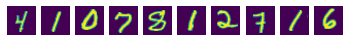

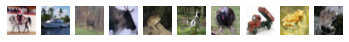

In [ ]:
mnist = {}
mnist["clf"] = {}
mnist["train"] = {}
mnist["test"] = {}
mnist["train"]["x"], mnist["train"]["y"] = get_np_data(
    name="mnist", split="train[:1000]", binary_labels=True
)
mnist["test"]["x"], mnist["test"]["y"] = get_np_data(
    name="mnist", split="test[:200]", binary_labels=True
)
mnist["train"]["xf"] = jnp.reshape(mnist["train"]["x"],
  (mnist["train"]["x"].shape[0], -1))
mnist["test"]["xf"] = jnp.reshape(mnist["test"]["x"],
  (mnist["test"]["x"].shape[0], -1))

cifar10 = {}
cifar10["clf"] = {}
cifar10["train"] = {}
cifar10["test"] = {}
cifar10["train"]["x"], cifar10["train"]["y"] = get_np_data(
    name="cifar10", split="train[:1000]", binary_labels=True
)
cifar10["test"]["x"], cifar10["test"]["y"] = get_np_data(
    name="cifar10", split="test[:200]", binary_labels=True
)
cifar10["train"]["xf"] = jnp.reshape(cifar10["train"]["x"],
  (cifar10["train"]["x"].shape[0], -1))
cifar10["test"]["xf"] = jnp.reshape(cifar10["test"]["x"],
  (cifar10["test"]["x"].shape[0], -1))

plot_sample_data(mnist["train"]["x"], 10, flat=False)
plot_sample_data(cifar10["train"]["x"], 10, flat=False)

In [ ]:
_, _, kernel_fn = stax.serial(
  stax.Dense(1, W_std=1, b_std=0), stax.Relu(),
  stax.Dense(1, W_std=1, b_std=0), stax.Relu(),
  stax.Dense(1, W_std=1, b_std=0), stax.Relu(),
  stax.Dense(1, W_std=1, b_std=0.1)
)
def ntk_f(A, B):
  return kernel_fn(A, B, "ntk")
clf_ntk = svm.SVC(C=100, kernel=ntk_f)
print(clf_ntk.fit(mnd["train_x"][:MN_TRAIN_SPLIT], mnd["train_y"][:MN_TRAIN_SPLIT]))
print("ntk test acc: {}".format(clf_data_acc(clf_ntk, mnd, MN_TEST_SPLIT)))